In [1]:
from utils import *

In [26]:
%%time
X, y = make_classification(n_samples=10**5 + 100, n_features=5, n_informative=5, n_redundant=0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=1,
    stratify=y,
    train_size=100,
    test_size=10**2
)
y_test_one_hot = get_one_hot_encoding(y_test)
y_test_one_hot.shape

CPU times: user 71.1 ms, sys: 6.73 ms, total: 77.8 ms
Wall time: 29.5 ms


(100, 2)

In [21]:
%%time

# create learner
clf = ExtraTreesClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

CPU times: user 47.5 ms, sys: 87 µs, total: 47.6 ms
Wall time: 46.1 ms


ExtraTreesClassifier(n_estimators=20, random_state=0)

In [27]:
y_pred = np.array([l.predict_proba(X_test) for l in clf])
y_pred.shape

(20, 100, 2)

In [48]:
class CovComputer:

    def __init__(self, clf, t=None):
        if t is None:
            t = len(clf)
        
        rows = []
        for s1, s2 in it.product(*(2 * [list(range(len(clf)))])):

            # get deltas and lambda for first pairs
            delta_1 = (y_test_one_hot - y_pred[s1])
            delta_2 = (y_test_one_hot - y_pred[s2])
            lambda_1 = (delta_1 * delta_2).sum(axis=1)

            second_pair_candidates = [i for i in range(len(clf)) if i not in [s1, s2]]
            for s3, s4 in it.product(*(2 * [second_pair_candidates])):
                delta_3 = (y_test_one_hot - y_pred[s3])
                delta_4 = (y_test_one_hot - y_pred[s4])
                lambda_2 = (delta_3 * delta_4).sum(axis=1)
                rows.append([lambda_1, lambda_2])
        
        self.lambdas_listwise = pd.DataFrame(rows, columns=["lamlist_1", "lamlist_2"])

covcom = CovComputer(clf)

In [58]:
pbar = tqdm(total=int(len(clf) * (len(clf) + 1) / 2))
covs = []
for i1 in range(len(clf)):
    for i2 in range(i1 + 1):
        covs.append(np.cov([
            covcom.lambdas_listwise["lamlist_1"].apply(lambda x: x[i1]),
            covcom.lambdas_listwise["lamlist_2"].apply(lambda x: x[i2])
        ], rowvar=True)[0, 1])
        pbar.update(1)

  0%|          | 0/210 [00:00<?, ?it/s]

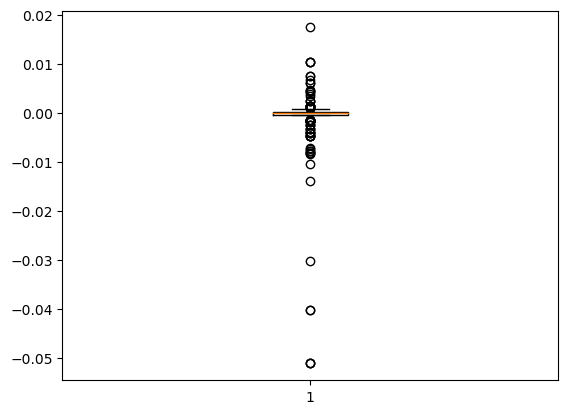

In [59]:
fig, ax = plt.subplots()
ax.boxplot(covs)
plt.show()